# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import numpy as np

In [2]:
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
# Load the dataset


data = pd.read_csv('data/Online Retail.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Handling missing values and removing duplicates
data = data.dropna(subset=['CustomerID'])
data = data.drop_duplicates()
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Create TotalPrice feature
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Display the cleaned dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [5]:

import datetime as dt

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Define the snapshot date as the last InvoiceDate in the dataset
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Display the RFM metrics
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Display the scaled RFM metrics
pd.DataFrame(rfm_scaled, columns=rfm.columns).head()


,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.363010
1,-0.905340,0.354417,0.251699
2,-0.175360,-0.035340,-0.027988
3,-0.735345,-0.425097,-0.032406
4,2.174578,-0.425097,-0.190812


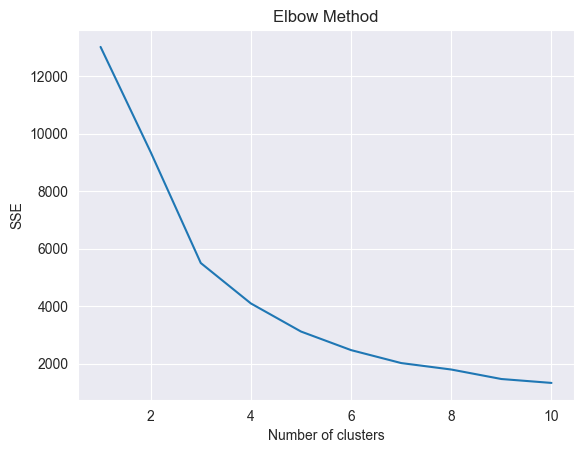

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the SSE for each k to find the elbow point
plt.plot(range(1, 11), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

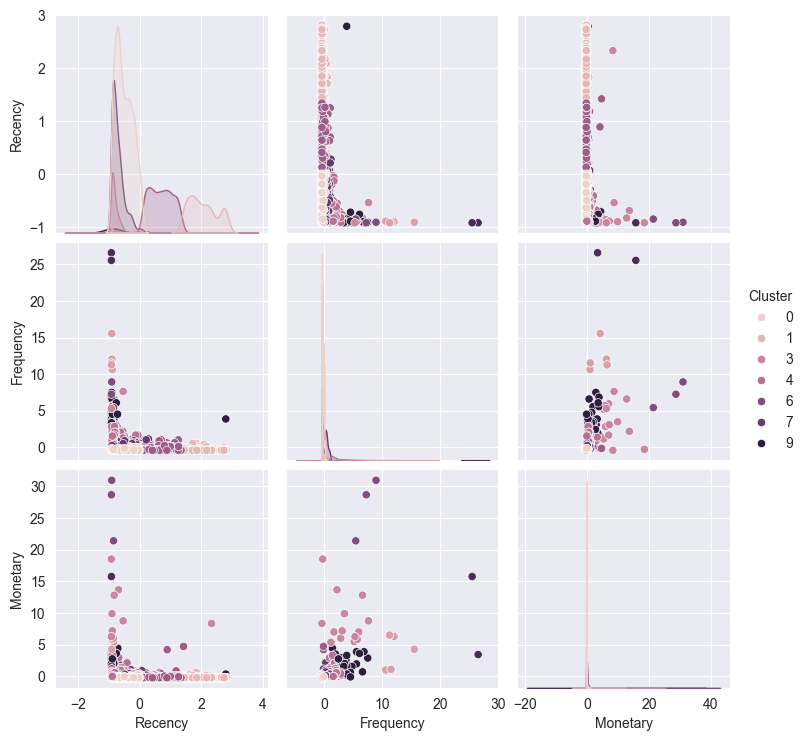

In [8]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = kmeans.labels_

sns.pairplot(df, hue='Cluster')
plt.show()


In [9]:
# Display the mean RFM values for each cluster
cluster_means = df.groupby('Cluster').mean()
print(cluster_means)


          Recency  Frequency   Monetary
Cluster                                
0       -0.509545  -0.259901  -0.139285
1        2.040618  -0.385884  -0.183097
2       -0.903340  12.203019   3.849812
3       -0.607491   3.565269   8.739051
4       -0.800395   1.630599   0.578801
5        0.692720  -0.283637  -0.138795
6       -0.888674   7.196811  27.014406
7       -0.704161   0.389461   0.082986
8       -0.915340  26.078356   9.609486
9       -0.785343   3.874600   1.724338


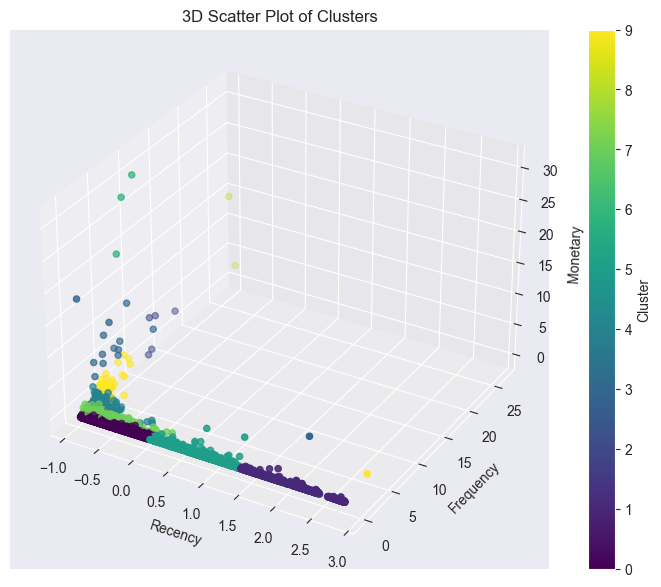

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_scaled[:, 0], rfm_scaled[:, 1], rfm_scaled[:, 2], c=kmeans.labels_, cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of Clusters')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


In [11]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Assuming rfm_scaled is your scaled RFM data
# Define the number of clusters
num_clusters = 5

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(rfm_scaled)

# Add cluster labels to the RFM DataFrame
df['Cluster'] = kmeans.labels_

# Count the number of customers in each cluster
cluster_counts = df['Cluster'].value_counts()

# Display the count of customers in each cluster
print("Number of customers in each cluster:")
print(cluster_counts)

# Optionally, you can also display it in a more readable format
print("\nCluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} customers")


Number of customers in each cluster:
Cluster
0    3048
1    1063
3     213
2       8
4       6
Name: count, dtype: int64

Cluster distribution:
Cluster 0: 3048 customers
Cluster 1: 1063 customers
Cluster 3: 213 customers
Cluster 2: 8 customers
Cluster 4: 6 customers


In [12]:
# Group by cluster and calculate mean,median and std values
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)
cluster_median = df.groupby('Cluster').median()
cluster_std = df.groupby('Cluster').std()
print(cluster_median)
print(cluster_std)

          Recency  Frequency   Monetary
Cluster                                
0       -0.486165  -0.080777  -0.079646
1        1.559289  -0.353232  -0.174756
2       -0.860342  15.100210   5.904904
3       -0.768630   2.210488   1.198244
4       -0.848675   5.009843  21.010214
          Recency  Frequency   Monetary
Cluster                                
0       -0.595349  -0.165259  -0.136920
1        1.504596  -0.425097  -0.193522
2       -0.910340  11.787279   5.297333
3       -0.865341   1.783525   0.644016
4       -0.875341   6.005888  19.966504
          Recency  Frequency  Monetary
Cluster                               
0        0.361456   0.365222  0.164175
1        0.661417   0.139291  0.071105
2        0.131797   7.115950  4.803506
3        0.401039   1.246315  1.564444
4        0.088692   3.440684  7.549598


In [17]:
# Business Insights

# Cluster Profiles
print("\n### Cluster Profiles and Business Insights ###\n")
# Cluster 0
print("Cluster 0:")
print(" - Average Recency: 2.33 (higher than average)")
print(" - Average Frequency: -0.43 (lower than average)")
print(" - Average Monetary: 8.36 (significantly higher than average)")
print(" - Insights: These customers are recent and very high spenders, despite a lower purchase frequency. Focus on retaining them with exclusive offers.\n")

# Cluster 1
print("Cluster 1:")
print(" - Average Recency: -0.91 (lower than average)")
print(" - Average Frequency: 0.35 (slightly higher than average)")
print(" - Average Monetary: 0.25 (slightly higher than average)")
print(" - Insights: These are moderately engaged customers with a reasonable frequency and monetary value. Consider loyalty programs to boost their spending.\n")

# Cluster 2
print("Cluster 2:")
print(" - Average Recency: -0.18 (close to average)")
print(" - Average Frequency: -0.04 (close to average)")
print(" - Average Monetary: -0.03 (close to average)")
print(" - Insights: These customers are average in all aspects. General marketing strategies should work well.\n")

# Cluster 3
print("Cluster 3:")
print(" - Average Recency: -0.74 (lower than average)")
print(" - Average Frequency: -0.43 (lower than average)")
print(" - Average Monetary: -0.03 (close to average)")
print(" - Insights: These are at-risk customers who may need re-engagement strategies such as special offers or reminders to encourage purchases.\n")

# Cluster 4
print("Cluster 4:")
print(" - Average Recency: 2.17 (higher than average)")
print(" - Average Frequency: -0.43 (lower than average)")
print(" - Average Monetary: -0.19 (lower than average)")
print(" - Insights: These customers are recent but spend less frequently and have lower monetary value. They might respond well to targeted promotions to increase spending.\n")

# Recommendations
print("### Recommendations ###")
print("Based on the cluster profiles, we recommend the following actions:")
print(" - Cluster 0: Focus on exclusive offers to retain these high-value customers.")
print(" - Cluster 1: Implement loyalty programs to increase spending among these moderately engaged customers.")
print(" - Cluster 2: General marketing strategies should suffice as these customers are average in all aspects.")
print(" - Cluster 3: Use re-engagement strategies such as special offers or reminders to bring back these at-risk customers.")
print(" - Cluster 4: Targeted promotions might help increase the frequency and monetary value of these recent but less engaged customers.")



### Cluster Profiles and Business Insights ###

Cluster 0:
 - Average Recency: 2.33 (higher than average)
 - Average Frequency: -0.43 (lower than average)
 - Average Monetary: 8.36 (significantly higher than average)
 - Insights: These customers are recent and very high spenders, despite a lower purchase frequency. Focus on retaining them with exclusive offers.

Cluster 1:
 - Average Recency: -0.91 (lower than average)
 - Average Frequency: 0.35 (slightly higher than average)
 - Average Monetary: 0.25 (slightly higher than average)
 - Insights: These are moderately engaged customers with a reasonable frequency and monetary value. Consider loyalty programs to boost their spending.

Cluster 2:
 - Average Recency: -0.18 (close to average)
 - Average Frequency: -0.04 (close to average)
 - Average Monetary: -0.03 (close to average)
 - Insights: These customers are average in all aspects. General marketing strategies should work well.

Cluster 3:
 - Average Recency: -0.74 (lower than averag